In [1]:
import torch, torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from PIL import Image
import matplotlib.pyplot as plt
import cv2, glob, numpy as np, pandas as pd

randint = lambda high: np.random.randint(high)
def stem(fpath): return '.'.join(fname(fpath).split('.')[:-1])
fname = lambda fpath: fpath.split('/')[-1]
def read(fname, mode=0):
    img = cv2.imread(str(fname), mode)
    if mode == 1: img = img[...,::-1] # BGR to RGB
    return img

def show(img=None, ax=None, title=None, sz=None, bbs=None, texts=None, bb_colors=None, cmap='gray', grid=False, save_path=None, text_sz=15, **kwargs):
    'show an image'
    try:
        if isinstance(img, torch.Tensor) and (img.device.type == 'cuda'): img = img.cpu()
    except: ...
    img = np.copy(img)
    if img.max() == 255: img = img.astype(np.uint8)
    h, w = img.shape[:2]
    if sz is None:
        if w<50: sz=1
        elif w<150: sz=2
        elif w<300: sz=5
        elif w<600: sz=10
        else: sz=20
    if isinstance(sz, int):
        sz = (sz, sz)
    if ax is None:
        fig, ax = plt.subplots(figsize=kwargs.get('figsize', sz))
        _show = True
    else: _show = False
    ax.imshow(img, cmap=cmap, **kwargs)
    ax.set_title(title)
    if not grid: ax.set_axis_off()
    if save_path:
        fig.savefig(save_path)
        return
    if _show: plt.show()

def train_and_validate_on(databunch, get_model_function, **expt_params):
    train_loader, test_loader = databunch
    model, criterion, optimizer = get_model_function(**expt_params)

    train_loss, test_loss = [], []
    try:
        n_epochs = expt_params.get('n_epochs', 10)
        import time
        start = time.time()
        for epoch in range(n_epochs):
            epoch_train_loss, epoch_test_loss = 0, 0

            for ix, (img,label) in enumerate(train_loader):
                # moving batch and lables to gpu
                img = img.to(device)
                label = label.to(device).float()

                model.train()
                optimizer.zero_grad()

                output = model(img).view(-1)
                loss = criterion(output, label)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()
                if ix > 3000/train_loader.batch_size: break # stop training at 3000 data points

            best_test_loss, accuracy =1000, 0
            for ix,(img,label) in enumerate(test_loader):
                with torch.no_grad():
                    img = img.to(device)
                    label = label.to(device).float()
                    model.eval()
                    ps = model(img).view(-1)
                    loss = criterion(ps,label)

                epoch_test_loss += loss.item()
                # from sklearn.metrics import confusion_matrix
                # print(confusion_matrix(label.cpu(), (ps > 0.5).cpu()))
                equality = label == (ps > 0.5)
                accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
            epoch_train_loss /= len(train_loader)
            epoch_test_loss /= len(test_loader)
            accuracy /= len(test_loader)
            train_loss.append(epoch_train_loss)
            test_loss.append(epoch_test_loss)
            
            if epoch_test_loss < best_test_loss:
                torch.save(model, '0.pth')
                best_test_loss = epoch_test_loss
            else: 'we already have a better model saved on disk'
                
            if epoch%expt_params.get('print_every', 1) == 0:
                elapsed = time.time()-start
                print('{}/{} ({:.2f}s - {:.2f}s remaining)'.format(epoch+1, n_epochs, time.time()-start, (n_epochs-epoch)*(elapsed/(epoch+1))))
                print(f'''Epoch: {epoch+1:03d}\tTrain Loss: {epoch_train_loss:.3f}\tTest: {epoch_test_loss:.3f}\t Best Test Loss: {best_test_loss:.3f}\tValidation Accuracy: {100*accuracy:.2f} %''')
    except KeyboardInterrupt:
        return model


In [2]:
!pip install --upgrade imgaug
import imgaug as ia
from imgaug import augmenters as iaa
import imgaug.augmenters.flip as flip

train_data_dir = '/kaggle/input/cat-and-dog/training_set/training_set'
test_data_dir = '/kaggle/input/cat-and-dog/test_set/test_set'

IMAGE_SIZE = 224
train_transform = iaa.Sequential([
    iaa.geometric.Affine(translate_px=(0,10), rotate=(-10,10), mode='reflect'),
    iaa.flip.Fliplr(0.5),
    iaa.PadToAspectRatio(1.0, pad_mode='reflect'),
    iaa.contrast.LinearContrast(),
    iaa.Sometimes(0.5, iaa.GaussianBlur()),
    iaa.size.Resize(IMAGE_SIZE),
    # iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # iaa.CenterCropToAspectRatio(1.0)
])
validation_transform = iaa.Sequential([
    iaa.size.Resize(IMAGE_SIZE),
])

class FilePathDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform, N=None):
        cats = glob.glob(data_dir+'/cats/*.jpg')
        dogs = glob.glob(data_dir+'/dogs/*.jpg')
        self.fpaths = cats + dogs
        
        from random import shuffle, seed
        seed(10); shuffle(self.fpaths)
        
        self.targets = [stem(fpath).startswith('dog') for fpath in self.fpaths] # dog=1 & cat=0
        
        self.N = len(self.fpaths) if N is None else N
        self.transform = transform
        
    def class_balance(self): return np.mean(self.targets)
    def __len__(self): return self.N
    def __getitem__(self, ix):
        im = read(self.fpaths[ix], 1)
        im = self.transform.augment_image(im)
        im = torch.tensor(im)
        im = im.permute(2, 0, 1) # HWC to CHW
        return im/255., self.targets[ix]

dataset = FilePathDataset(train_data_dir, transform=train_transform, N=3000)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=16)

dataset = FilePathDataset(test_data_dir, transform=validation_transform, N=100)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=16)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}\n')
print(f'''Train\t\t{len(train_loader.dataset)} examples
Validation\t{len(test_loader.dataset)} examples
Image Size\t{train_loader.dataset[0][0].shape}
Train Class balance:\t{train_loader.dataset.class_balance():.3f}
Test Class balance:\t{test_loader.dataset.class_balance():.3f}''')

     |████████████████████████████████| 948 kB 6.7 MB/s 
ERROR: albumentations 0.4.3 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.6
    Uninstalling imgaug-0.2.6:
      Successfully uninstalled imgaug-0.2.6
Using device: cuda

Train		3000 examples
Validation	100 examples
Image Size	torch.Size([3, 224, 224])
Train Class balance:	0.500
Test Class balance:	0.500


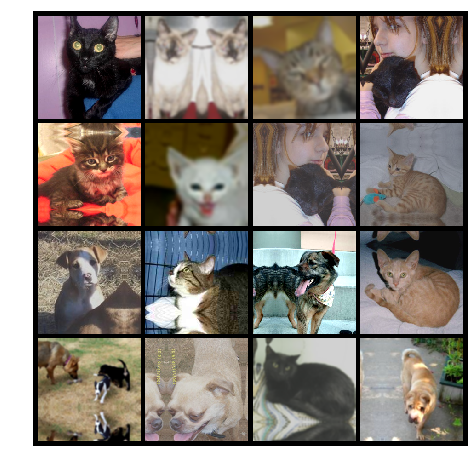

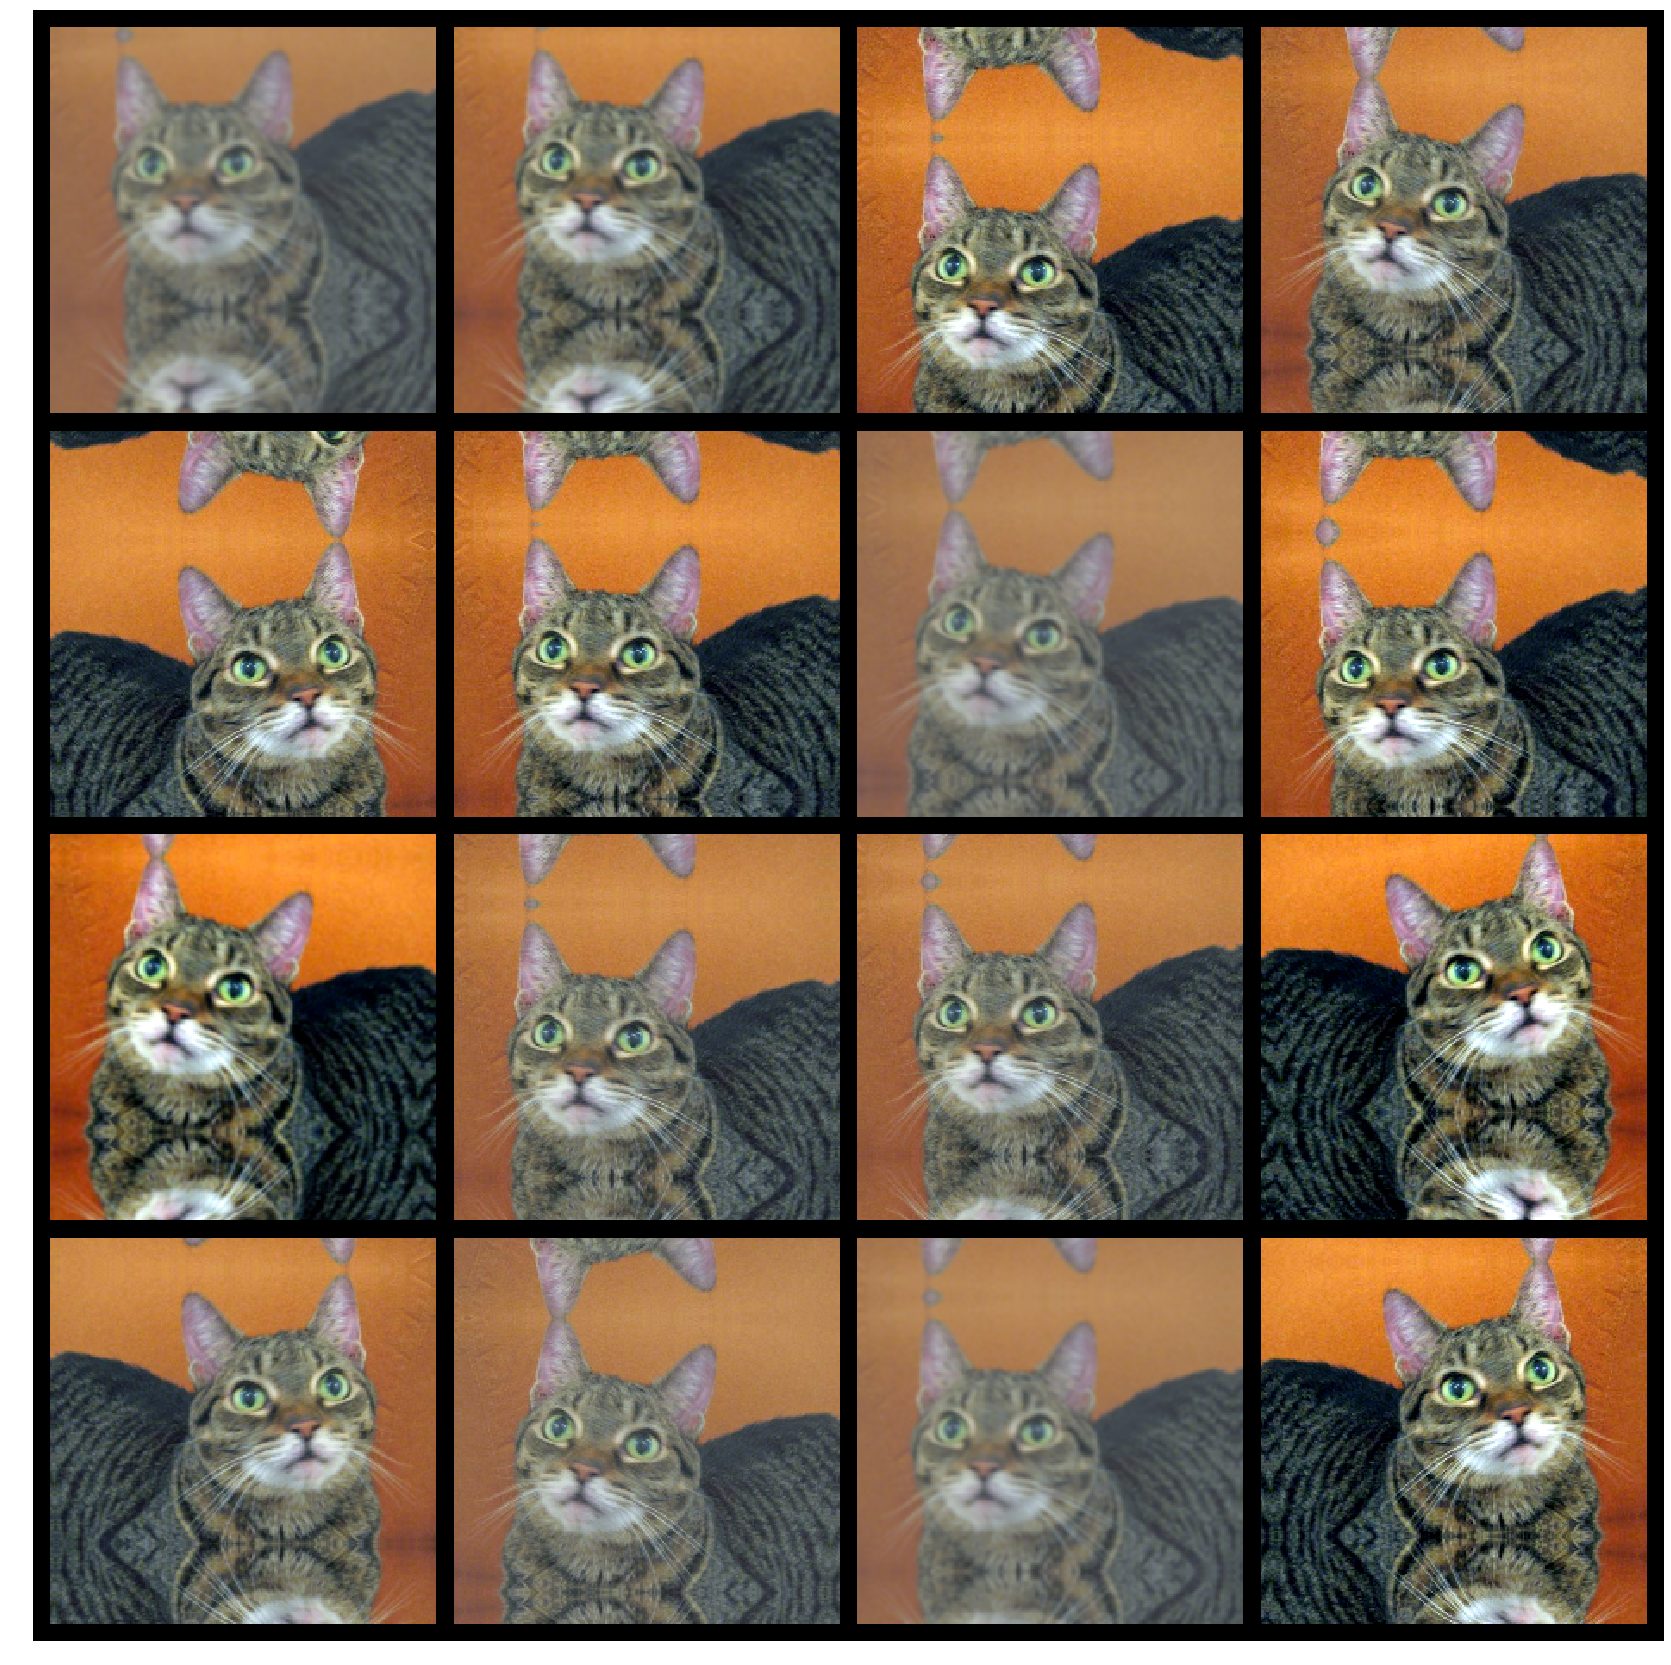

In [3]:
# Let's fetch the images from indexes given by `ixs` and plot them in a grid
def show_grid(ixs, dataloader, sz=8):
    inputs, classes = zip(*[dataloader.dataset[ix] for ix in ixs])
    inputs = torch.stack(inputs)
    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs, scale_each=True, nrow=int(np.sqrt(len(inputs))), padding=10)
    # and see
    show(out.numpy().transpose((1, 2, 0)), sz=sz)
    
show_grid(np.random.randint(0, 100, size=16), train_loader)
# dogs and cats still look like dogs and cats. Notice the automatic rotation of images

# let's plot the 10th image 16 times from dataloader and plot. 
show_grid([10]*16, train_loader, sz=30)
# notice how the same image is being loaded differently everytime. 
# this way we get infinite variations of the same cat thereby making the model very generalized

In [4]:
class Identity(nn.Module):
    def __init__(self)  :  super(Identity, self).__init__()
    def forward(self, x):  return x
    
def conv_layer(ni,no,kernel_size,pool_size, stride=1,drop=0.2,bn=True,padding='same'):
    padding = 1 if kernel_size==3 else 0
    return nn.Sequential(
        nn.Conv2d(ni, no, kernel_size, stride, padding=padding),
        nn.ReLU(),
        nn.MaxPool2d(pool_size) if pool_size is not None else Identity(),
        nn.BatchNorm2d(no) if bn else Identity(),
        nn.Dropout(drop) if drop is not None else Identity()
    )
def get_model(**kwargs):
    model = nn.Sequential(
        conv_layer(3, 64, 3, pool_size=None),
        conv_layer(64, 64, 3, pool_size=None),
        conv_layer(64, 128, 3, pool_size=None, stride=2),
        conv_layer(128, 256, 3, pool_size=None),
        conv_layer(256, 256, 3, pool_size=None),
        conv_layer(256, 512, 3, pool_size=None, stride=2),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(512, 64),
        nn.ReLU(),
        nn.Linear(64, 1),
        nn.Sigmoid(),
    ).to(device)

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs.get('lr', 1e-3))
    return model, loss_fn, optimizer

try:
    from torchsummary import summary
except:
    !pip install torchsummary
    from torchsummary import summary

model, criterion, optimizer = get_model()
summary(model, input_size=(3,IMAGE_SIZE,IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
          Identity-3         [-1, 64, 224, 224]               0
       BatchNorm2d-4         [-1, 64, 224, 224]             128
           Dropout-5         [-1, 64, 224, 224]               0
            Conv2d-6         [-1, 64, 224, 224]          36,928
              ReLU-7         [-1, 64, 224, 224]               0
          Identity-8         [-1, 64, 224, 224]               0
       BatchNorm2d-9         [-1, 64, 224, 224]             128
          Dropout-10         [-1, 64, 224, 224]               0
           Conv2d-11        [-1, 128, 112, 112]          73,856
             ReLU-12        [-1, 128, 112, 112]               0
         Identity-13        [-1, 128, 112, 112]               0
      BatchNorm2d-14        [-1, 128, 1

In [5]:
model = train_and_validate_on((train_loader, test_loader), get_model, n_epochs=50)

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Identity. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1/50 (77.86s - 3893.15s remaining)
Epoch: 001	Train Loss: 0.701	Test: 0.736	 Best Test Loss: 0.736	Validation Accuracy: 48.21 %
2/50 (154.32s - 3780.78s remaining)
Epoch: 002	Train Loss: 0.683	Test: 0.633	 Best Test Loss: 0.633	Validation Accuracy: 66.96 %
3/50 (229.42s - 3670.75s remaining)
Epoch: 003	Train Loss: 0.682	Test: 0.669	 Best Test Loss: 0.669	Validation Accuracy: 66.96 %
4/50 (305.37s - 3588.10s remaining)
Epoch: 004	Train Loss: 0.677	Test: 0.650	 Best Test Loss: 0.650	Validation Accuracy: 61.61 %
5/50 (381.02s - 3505.38s remaining)
Epoch: 005	Train Loss: 0.672	Test: 0.712	 Best Test Loss: 0.712	Validation Accuracy: 59.82 %
6/50 (457.22s - 3429.19s remaining)
Epoch: 006	Train Loss: 0.665	Test: 0.607	 Best Test Loss: 0.607	Validation Accuracy: 62.50 %
7/50 (533.07s - 3350.72s remaining)
Epoch: 007	Train Loss: 0.664	Test: 0.579	 Best Test Loss: 0.579	Validation Accuracy: 64.29 %
8/50 (609.00s - 3273.38s remaining)
Epoch: 008	Train Loss: 0.662	Test: 0.588	 Best Test Loss: 0.58